# Cross-validation of embedding methods

Perform cross-validation of an embedding method to tune hyperparameters and evaluate the accuracy of classifications based on Euclidean distances of embedded space.

## Analysis outline

1. Load genome sequences from a FASTA file
1. Load clade membership annotations for each genome from a separate metadata file
1. Calculate a pairwise distance matrix from the genome sequences.
1. For each fold in a *k-fold* analysis
  1. Identify sequences in the fold
  1. Subset the distance matrix to only those sequences in the fold
  1. Apply the current embedding method (e.g., MDS, t-SNE, UMAP) to the distance matrix
  1. Calculate the pairwise Euclidean distance between sequences in the embedding
  1. Calculate and store the Pearson's correlation between genetic and Euclidean distances for all pairs in the embedding
  1. Calculate and store a distance threshold below which any pair of sequences are assigned to the same clade
  1. Apply the current embeddng method to the subset of the distance matrix corresponding to the validation data for the current fold
  1. Calculate the pairwise Euclidean distance between sequences in the validation embedding
  1. Assign all pairs of sequences in the validation set to estimated "within" or "between" clade statuses based on their distances
  1. Calculate the confusion matrix from the estimated and observed clade identities
  1. Calculate and store accuracy, Matthew's correlation coefficient, etc. from the confusion matrix
1. Plot the distribution of Pearson's correlations across all *k* folds
1. Plot the distribution of accuracies, etc. across all *k* folds

In [1]:
import sys
sys.path.append("../notebooks/scripts")

## Imports

In [2]:
from augur.utils import read_node_data
import Bio.SeqIO
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import statsmodels
import statistics
from umap import UMAP

from Helpers import get_hamming_distances, get_euclidean_data_frame, scatterplot_xyvalues

%matplotlib inline

In [3]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [4]:
def assign_clade_status_to_pairs(clade_annotations, index):
    """Assign clade status to all pairs in the given list of indices and the given data frame of clade annotations.
    
    Outputs a vector in condensed distance matrix format such that all nonredundant pairs of strains are represented.
    
    """
    clade_statuses = []
    for i in range(len(index)):
        for j in range(i + 1, len(index)):
            same_clade = clade_annotations.loc[index[i], "clade_membership"] == clade_annotations.loc[index[j], "clade_membership"]
            clade_statuses.append(int(same_clade))
            
    return np.array(clade_statuses)

## Define inputs, outputs, and parameters

In [5]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Load node dataframe

In [6]:
node_df = pd.read_csv("../seasonal-flu-nextstrain/results/table.tsv", sep="\t")
node_df

,strain,num_date,pca1,pca2,pca3,pca4,mds1,mds2,mds3,mds4,tsne_x,tsne_y,umap_x,umap_y,clade_membership,pca_label,mds_label,umap_label,t-sne_label,y_value
0,A/Chungbuk/107/2016,2016.05,-1.53,5.05,-0.82,-0.71,0.56,-3.39,-5.75,7.65,11.42,-39.81,7.13,4.69,3c3,2,-1,3,2,1
1,A/MUWRP-Uganda/579/2016,2016.67,-1.16,5.42,-1.00,-0.59,6.79,-6.77,-22.62,1.60,11.02,-39.65,-11.28,14.39,3c3,2,-1,1,2,2
2,A/Shiraz/1011/2015,2015.89,-1.44,5.35,-0.89,-0.68,-3.96,6.47,-17.01,17.92,10.31,-38.83,-10.77,13.86,3c3.B,2,-1,1,2,3
3,A/Shiraz/1019/2016,2016.00,-1.58,5.34,-0.86,-0.76,-4.10,0.48,-16.83,7.69,10.36,-38.88,-10.67,13.64,3c3,2,-1,1,2,4
4,A/Shiraz/1020/2016,2016.02,-1.59,5.33,-0.87,-0.75,2.90,-11.97,-12.90,13.21,10.38,-38.91,-10.73,13.44,3c3,2,-1,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,A/Japan/6792/2018,2018.02,-3.06,-1.25,-2.38,1.74,-5.12,-9.88,7.98,-5.56,53.43,-13.85,-7.42,1.24,A1b/135N,3,-1,2,14,1146
1146,A/SouthKorea/7182/2018,2018.14,-3.06,-1.25,-2.40,1.71,-3.69,-9.36,6.05,-4.40,53.51,-13.91,-7.33,1.07,A1b/135N,3,-1,2,14,1147
1147,A/SouthKorea/7183/2018,2018.15,-3.06,-1.25,-2.39,1.71,-4.07,-8.75,7.10,-1.99,53.60,-13.95,-7.10,1.40,A1b/135N,3,-1,2,14,1148
1148,A/SouthKorea/6968/2018,2018.16,-3.05,-1.24,-2.38,1.74,-3.41,-8.85,6.86,-3.92,53.39,-13.86,-7.46,1.00,A1b/135N,3,-1,2,14,1149


In [7]:
# Build a data frame of clade annotations per strain in the same order
# as the sequences and the subsequent distance matrix.

clade_annotations = node_df[["strain", "clade_membership"]]

In [8]:
len(clade_annotations)

1150

In [9]:
clade_annotations.shape

(1150, 2)

## Calculate distance matrix

In [10]:
#hamming_distances = get_hamming_distances(
#    sequences_by_name.values()
#)
distance_matrix = pd.read_csv("../seasonal-flu-nextstrain/results/distance_matrix.csv", index_col=0)
distance_matrix.reset_index(drop=True)

distance_matrix = distance_matrix.to_numpy()

In [11]:
distance_matrix.shape

(1150, 1150)

<AxesSubplot:>

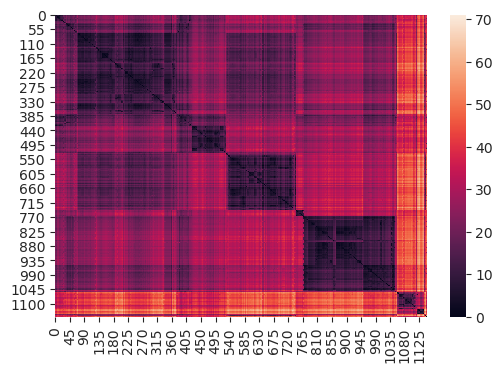

In [12]:
sns.heatmap(distance_matrix)

## Assign sequences to k-fold groups and analyze each fold

For each fold, use the training indices to subset the distance matrix to just those columns and rows that belong in the training data. Apply a given embedding method to the distance matrix subset, identify the classification threshold for clade membership, and validate that threshold on the subset of the distance matrix corresponding to the validation indices.

In [13]:
tuned_parameter_values = []
list_of_embeddings = []
default_tuned_values = []
list_of_embeddings_strings = ["TSNE", "UMAP"]

In [14]:
embedding_class = TSNE
list_of_embeddings.append(embedding_class)
embedding_parameters = {
    "metric": "precomputed",
    "perplexity": 15,
    "learning_rate": 100.0
}
tuned_parameters_TSNE = {
    "perplexity": [15, 30, 100],
    "learning_rate": [100.0, 200.0, 500.0, 1000.0]
}

tuned_parameter_values.append(tuned_parameters_TSNE)
default_tuned_values.append(embedding_parameters)

In [15]:
embedding_class = UMAP
list_of_embeddings.append(embedding_class)
embedding_parameters = {
    "init": "spectral",
    "n_neighbors" : 25,
    "min_dist" : .05
}
tuned_parameters_UMAP = {
    "n_neighbors" : [25, 100, 200],
    "min_dist" : [.05, .5]}
tuned_parameter_values.append(tuned_parameters_UMAP)
default_tuned_values.append(embedding_parameters)

In [16]:
embedding_class = MDS
list_of_embeddings.append(embedding_class)
embedding_parameters = {
    "dissimilarity": "precomputed",
    "n_components" : 10
}
default_tuned_values.append(embedding_parameters)

In [17]:
embedding_class = PCA
embedding_parameters = {
    "n_components" : 10,
    "svd_solver" : "full"
}
default_tuned_values.append(embedding_parameters)

# Exhaustive Grid Search

In [34]:
try:
    snakemake.output.exhaustive_grid_search
    grid_search_results = []
    i = 0
    fold_factory = KFold(n_splits=5, shuffle=True)
    folds = fold_factory.split(sequence_names)
    for k, (training_index, validation_index) in enumerate(folds): 
        i = 0
        for embed in tuned_parameter_values:
            keys, values = zip(*embed.items())
            experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
            for experiment in experiments:

                method_dict = default_tuned_values[i].copy()
                experiment_tuple = [(k, v) for k, v in experiment.items()]
                method_dict.update(experiment_tuple)

                embedder = list_of_embeddings[i](**method_dict)

                training_distance_matrix = distance_matrix[training_index][:, training_index]
                training_embedding = embedder.fit_transform(training_distance_matrix)

                training_embedding_distances = pdist(training_embedding).reshape(-1, 1)


                training_clade_status_for_pairs = assign_clade_status_to_pairs(
                    clade_annotations,
                    training_index
                )

                classifier = make_pipeline(
                    StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5)
                )

                classifier.fit(training_embedding_distances, training_clade_status_for_pairs)
                classifier_threshold = (0.5 - classifier.named_steps["linearsvc"].intercept_) / classifier.named_steps["linearsvc"].coef_[0]


                validation_distance_matrix = distance_matrix[validation_index][:, validation_index]

                validation_embedding = embedder.fit_transform(validation_distance_matrix)

                validation_embedding_distances = pdist(validation_embedding).reshape(-1, 1)

                validation_clade_status_for_pairs = assign_clade_status_to_pairs(
                    clade_annotations,
                    validation_index
                )

                if(list_of_embedding_strings[i] =="UMAP" and method_dict["n_neighbors"] == 5 and k==0):
                    training_embedding_df = pd.DataFrame(training_embedding, columns=["x", "y"])
                    training_embedding_df["clade_membership"] = clade_annotations.loc[training_index, "clade_membership"].values

                    validation_embedding_df = pd.DataFrame(validation_embedding, columns=["x", "y"])
                    validation_embedding_df["clade_membership"] = clade_annotations.loc[validation_index, "clade_membership"].values

                if(k==0):
                    print("here")
                    training_embedding_df_1 = pd.DataFrame(training_embedding, columns=["x", "y"])
                    training_embedding_df_1["clade_membership"] = clade_annotations.loc[training_index, "clade_membership"].values

                    validation_embedding_df_1 = pd.DataFrame(validation_embedding, columns=["x", "y"])
                    validation_embedding_df_1["clade_membership"] = clade_annotations.loc[validation_index, "clade_membership"].values

                confusion_matrix_val = confusion_matrix(validation_clade_status_for_pairs, classifier.predict(validation_embedding_distances))
                matthews_cc_val = matthews_corrcoef(validation_clade_status_for_pairs, classifier.predict(validation_embedding_distances))

                accuracy = classifier.score(
                    validation_embedding_distances,
                    validation_clade_status_for_pairs
                )
                method_dict["method"] = list_of_embeddings_strings[i]
                method_dict["fold"] = k
                method_dict["confusion_matrix"] = confusion_matrix_val
                method_dict["matthews_cc"] = matthews_cc_val
                method_dict["threshold"] = classifier_threshold
                method_dict["accuracy"] = accuracy

                print(method_dict)
                grid_search_results.append(method_dict)
            i = i + 1
except:
    print("not in snakemake")

not in snakemake


# Grid Search Plot

In [ ]:
df = pd.DataFrame(grid_search_results)

In [35]:
df

,mean,method
0,0.227666,t-SNE
1,0.267104,UMAP
2,0.291803,MDS
3,0.321330,PCA
4,0.832876,genetic


In [437]:
filter = df['matthews_cc'] == 0.0
  
# filtering data 
df.where(filter, inplace = True)
  
df.dropna(how="all")

,metric,perplexity,learning_rate,method,fold,confusion_matrix,matthews_cc,threshold,accuracy,init,n_neighbors,min_dist
7,precomputed,30.0,1000.0,TSNE,0.0,"[[23297, 3038], [0, 0]]",0.0,[-1.6434456497659857],0.884640,NaN,NaN,NaN
11,precomputed,100.0,1000.0,TSNE,0.0,"[[23297, 3038], [0, 0]]",0.0,[-1.3194930966708434],0.884640,NaN,NaN,NaN
29,precomputed,100.0,1000.0,TSNE,1.0,"[[23570, 2765], [0, 0]]",0.0,[-1.3657906585836503],0.895007,NaN,NaN,NaN
47,precomputed,100.0,1000.0,TSNE,2.0,"[[23591, 2744], [0, 0]]",0.0,[-1.4765981763411289],0.895804,NaN,NaN,NaN
65,precomputed,100.0,1000.0,TSNE,3.0,"[[23293, 3042], [0, 0]]",0.0,[-1.3220939952305215],0.884488,NaN,NaN,NaN
83,precomputed,100.0,1000.0,TSNE,4.0,"[[23106, 3229], [0, 0]]",0.0,[-1.4222502965737298],0.877388,NaN,NaN,NaN


Text(0.5, 1.0, 'UMAP')

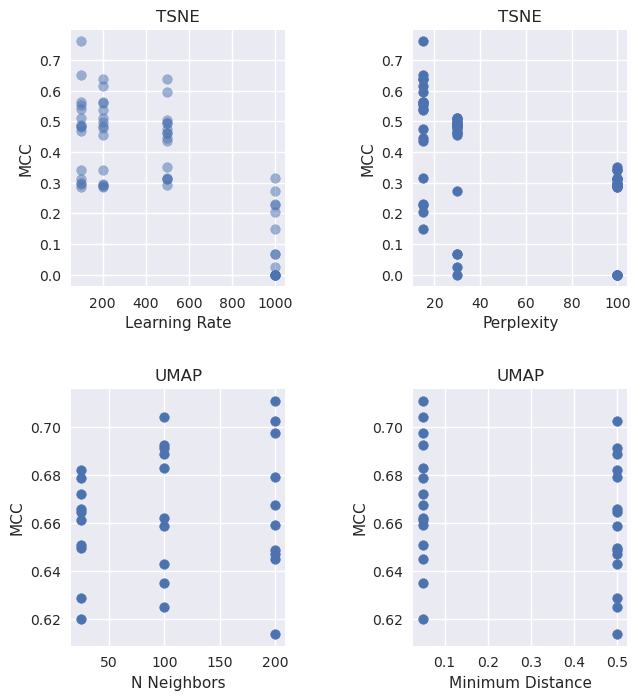

In [440]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Creates two subplots and unpacks the output array immediately
ax1.scatter(df["learning_rate"], df["matthews_cc"], label="learning rate", alpha=.5)
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("MCC")
ax1.set_title('TSNE')

ax2.scatter(df["perplexity"], df["matthews_cc"], label="perplexity")
ax2.set_xlabel("Perplexity")
ax2.set_ylabel("MCC")
ax2.set_title('TSNE')

ax3.scatter(df["n_neighbors"], df["matthews_cc"], label="n neighbors")
ax3.set_xlabel("N Neighbors")
ax3.set_ylabel("MCC")
ax3.set_title("UMAP")

ax4.scatter(df["min_dist"], df["matthews_cc"], label="minimum distance")
ax4.set_xlabel("Minimum Distance")
ax4.set_ylabel("MCC")
ax4.set_title("UMAP")

plt.savefig(snakemake.output.exhaustive_grid_search)

In [418]:
training_embedding_df = pd.DataFrame(training_embedding, columns=["x", "y"])
training_embedding_df["clade_membership"] = clade_annotations.loc[training_index, "clade_membership"].values

validation_embedding_df = pd.DataFrame(validation_embedding, columns=["x", "y"])
validation_embedding_df["clade_membership"] = clade_annotations.loc[validation_index, "clade_membership"].values

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


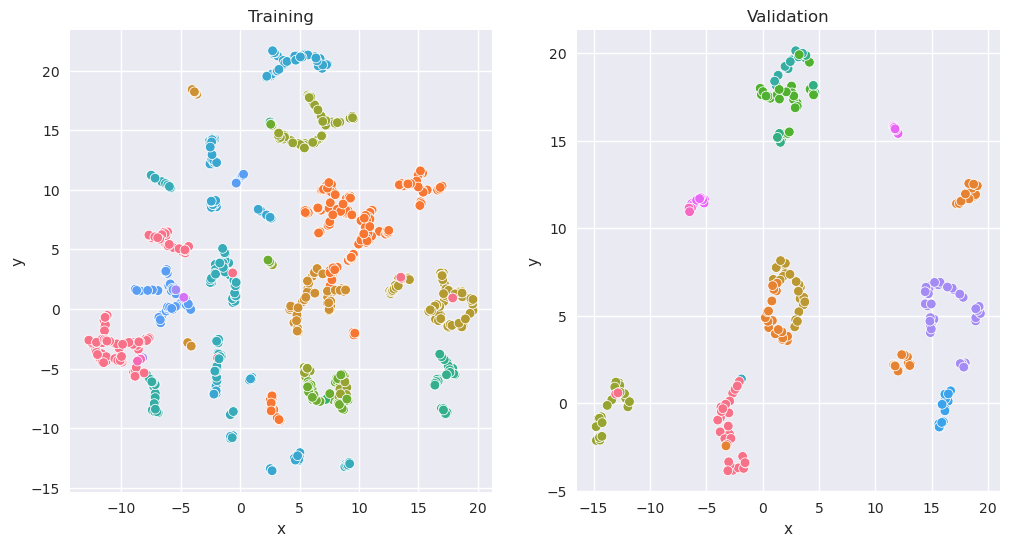

In [422]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot("x", "y", hue="clade_membership", data=training_embedding_df, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("x", "y", hue="clade_membership", data=validation_embedding_df, legend=False, ax=axes[1])
axes[1].set_title("Validation")

sns.despine()

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


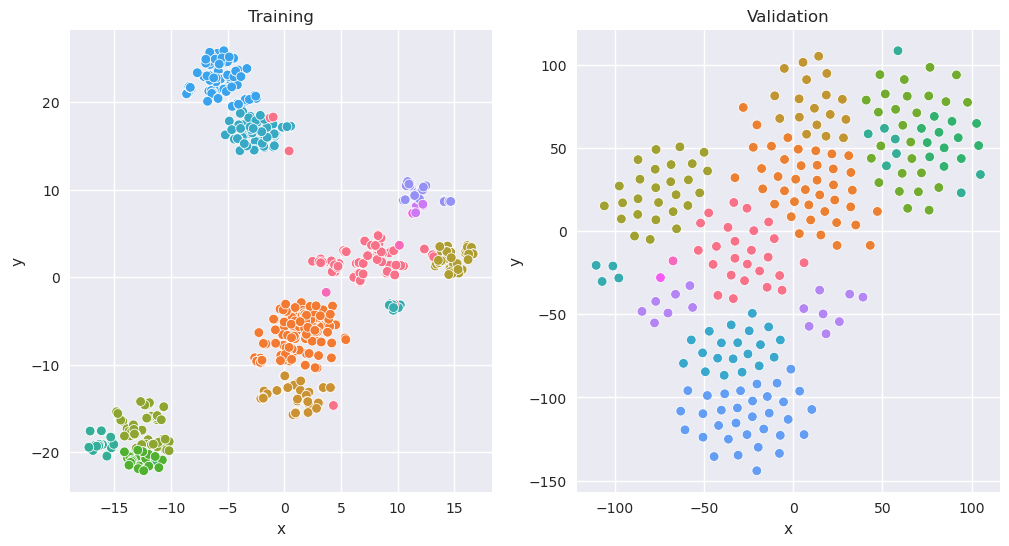

In [431]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot("x", "y", hue="clade_membership", data=training_embedding_df_1, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("x", "y", hue="clade_membership", data=validation_embedding_df_1, legend=False, ax=axes[1])
axes[1].set_title("Validation")

sns.despine()

In [ ]:
# NOTES

# all N neighbors with value of 5 have an MCC of 0
# learning rate 1000 with perplexity 100 always gave MCC of 0
# perplex of 30 and learning rate 1000 gave MCC 0 once

In [252]:
df = pd.DataFrame(grid_search_results)

In [300]:
df_TSNE = df[df.method == 'TSNE'].dropna(axis = 1)
df_UMAP = df[df.method == 'UMAP'].dropna(axis = 1)
df_MDS = df[df.method == 'MDS'].dropna(axis = 1)

In [266]:
list_of_results = [TSNE_dictionary, UMAP_dictionary, MDS_dictionary]

In [296]:
#perplexity: 15, learning rate: 100
TSNE_grouped = pd.DataFrame(df_TSNE.groupby(["perplexity", "learning_rate"])['matthews_cc'].mean())
TSNE_grouped.iloc[TSNE_grouped["matthews_cc"].argmax()]

matthews_cc    0.636214
Name: (15.0, 100.0), dtype: float64

In [297]:
# neighbors: 25, min_dist: .05
UMAP_grouped = pd.DataFrame(df_UMAP.groupby(["n_neighbors", "min_dist"])['matthews_cc'].mean())
UMAP_grouped.iloc[UMAP_grouped["matthews_cc"].argmax()]

matthews_cc    0.761824
Name: (25.0, 0.05), dtype: float64

# Main Classification Work

### For PCA

In [18]:
import re

In [19]:
total_list_methods = []

In [20]:
list_of_embedding_strings = ["t-SNE","UMAP","MDS", "PCA"]

In [21]:
embedding_class = [TSNE, UMAP, MDS, PCA]

In [22]:
default_tuned_values

[{'metric': 'precomputed', 'perplexity': 15, 'learning_rate': 100.0},
 {'init': 'spectral', 'n_neighbors': 25, 'min_dist': 0.05},
 {'dissimilarity': 'precomputed', 'n_components': 10},
 {'n_components': 10, 'svd_solver': 'full'}]

In [23]:
import Bio.SeqIO
from collections import OrderedDict

sequences_by_name = OrderedDict()

for sequence in Bio.SeqIO.parse("../seasonal-flu-nextstrain/results/aligned.fasta", "fasta"):
    sequences_by_name[sequence.id] = str(sequence.seq)

sequence_names = list(sequences_by_name.keys())

numbers = list(sequences_by_name.values())[:]
for i in range(0,len(list(sequences_by_name.values()))):
    numbers[i] = re.sub(r'[^AGCT]', '5', numbers[i])
    numbers[i] = list(numbers[i].replace('A','1').replace('G','2').replace('C', '3').replace('T','4'))
    numbers[i] = [int(j) for j in numbers[i]]

In [24]:
numbers = np.array(numbers)

In [25]:
fold_factory = KFold(n_splits=5, shuffle=True)
folds = fold_factory.split(sequence_names)

In [26]:
for k, (training_index, validation_index) in enumerate(folds):
    print(f"Fit to fold: {k}")
    i = 0
    print("here")
    for embed in default_tuned_values:
        print(i)
    # Calculate Euclidean distance between pairs of samples in the embedding.
    # The output is a condensed distance matrix with distances between pairs.
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        scaler = StandardScaler()
        if(list_of_embedding_strings[i] == "PCA"):
            #performing PCA on my pandas dataframe
            numbers_subset = numbers[training_index]
            pca = PCA(**embed) #can specify n, since with no prior knowledge, I use None
            training_embedding = pca.fit_transform(numbers_subset)
        else:
            # Subset distance matrix to training indices.
            training_distance_matrix = distance_matrix[training_index][:, training_index]

            # Embed training distance matrix.
            print(embedding_class[i])
            embedder = embedding_class[i](**embed)
            training_embedding = embedder.fit_transform(training_distance_matrix)
            

        # Calculate Euclidean distance between pairs of samples in the embedding.
        # The output is a condensed distance matrix with distances between pairs.
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        training_embedding_distances = pdist(training_embedding).reshape(-1, 1)
        training_embeddings_distances = scaler.fit_transform(training_embedding_distances).flatten()
        
        # Assign a binary class to each pair of samples based on their clade memberships.
        # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
        # This vector of binary values will be the output to fit a classifier to.
        # These pairs should be in the same order as the embedding distances above.
        training_clade_status_for_pairs = assign_clade_status_to_pairs(
            clade_annotations,
            training_index
        )

        # Use a support vector machine classifier to identify an optimal threshold
        # to distinguish between within and between class pairs.
        # See also: https://scikit-learn.org/stable/modules/svm.html#svm-classification
        classifier = LinearSVC(
            dual=False,
            random_state=0,
            class_weight={1: 5},
            verbose=0
        )
        X = np.array(training_embedding_distances).reshape(-1,1)
        y = training_clade_status_for_pairs.astype(float)
        classifier.fit(X, y)

        x_range = np.linspace(-3, 3, 1000)
        z = classifier.decision_function(x_range.reshape(-1, 1))
        try:
            classifier_threshold = x_range[np.argwhere(z > 0)[-1]][0]
        except:
            classifier_threshold = "NaN"

        # Use a SVM to identify an optimal threshold for genetic distances.
        genetic_classifier = make_pipeline(
            StandardScaler(),
            LinearSVC(
                dual=False,
                random_state=0,
                class_weight={1: 5},
                verbose=0
            )
        )
        genetic_classifier.fit(squareform(training_distance_matrix).reshape(-1, 1), training_clade_status_for_pairs)
        
        if(list_of_embedding_strings[i] == "PCA"):
            #performing PCA on my pandas dataframe
            numbers_subset = numbers[validation_index]
            pca = PCA(**embed) #can specify n, since with no prior knowledge, I use None
            validation_embedding = pca.fit_transform(numbers_subset)
        else:
            # Subset distance matrix to validation indices.
            validation_distance_matrix = distance_matrix[validation_index][:, validation_index]

            # Embed validation distance matrix.
            validation_embedding = embedder.fit_transform(validation_distance_matrix)

        # Calculate Euclidean distance between pairs of samples in the embedding.
        # The output should be a data frame of distances between pairs.
        validation_embedding_distances = pdist(validation_embedding).reshape(-1, 1)
        validation_embeddings_distances = scaler.fit_transform(validation_embedding_distances).flatten()

        # Assign a binary class to each pair of samples based on their clade memberships.
        # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
        # This vector of binary values will be the output to fit a classifier to.
        # These pairs should be in the same order as the embedding distances above.
        validation_clade_status_for_pairs = assign_clade_status_to_pairs(
            clade_annotations,
            validation_index
        )

        # Predict and score clade status from embedding distances and the trained classifier.
        # The first argument is the set to predict classifier labels for. The second argument
        # is the list of true labels. The return argument is the mean accuracy of the predicted
        # labels.
        # https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.score

        confusion_matrix_val = confusion_matrix(validation_clade_status_for_pairs, classifier.predict(validation_embedding_distances))
        matthews_cc_val = matthews_corrcoef(validation_clade_status_for_pairs, classifier.predict(validation_embedding_distances))
        
        accuracy = classifier.score(
            validation_embedding_distances,
            validation_clade_status_for_pairs
        )
        
        genetic_accuracy = genetic_classifier.score(
            squareform(validation_distance_matrix).reshape(-1, 1),
            validation_clade_status_for_pairs
        )
        method_dict = {}
        
        method_dict["method"] = list_of_embedding_strings[i]

        method_dict["fold"] = k
        method_dict["confusion_matrix"] = confusion_matrix_val
        method_dict["matthews_cc"] = matthews_cc_val
        method_dict["threshold"] = classifier_threshold
        method_dict["accuracy"] = accuracy


        print(method_dict)
        total_list_methods.append(method_dict)
        i = i + 1
    total_list_methods.append({"method":"genetic", "matthews_cc": genetic_accuracy, "fold":k})

Fit to fold: 0
here
0
<class 'sklearn.manifold._t_sne.TSNE'>
{'method': 't-SNE', 'fold': 0, 'confusion_matrix': array([[16320,  7056],
       [  994,  1965]]), 'matthews_cc': 0.24105332955950143, 'threshold': 3.0, 'accuracy': 0.6943231441048034}
1
<class 'umap.umap_.UMAP'>
{'method': 'UMAP', 'fold': 0, 'confusion_matrix': array([[19172,  4204],
       [ 1138,  1821]]), 'matthews_cc': 0.327476468537568, 'threshold': 3.0, 'accuracy': 0.7971520789823429}
2
<class 'sklearn.manifold._mds.MDS'>
{'method': 'MDS', 'fold': 0, 'confusion_matrix': array([[19816,  3560],
       [ 1514,  1445]]), 'matthews_cc': 0.2704961248763802, 'threshold': 3.0, 'accuracy': 0.8073286500854376}
3
{'method': 'PCA', 'fold': 0, 'confusion_matrix': array([[19640,  3736],
       [ 1430,  1529]]), 'matthews_cc': 0.28182576008184135, 'threshold': 3.0, 'accuracy': 0.8038352003037782}
Fit to fold: 1
here
0
<class 'sklearn.manifold._t_sne.TSNE'>
{'method': 't-SNE', 'fold': 1, 'confusion_matrix': array([[17405,  5892],
    

In [51]:
validation_clade_status_for_pairs

array([0, 0, 0, ..., 1, 1, 1])

In [52]:
classifier.predict(validation_embedding_distances)

array([1., 1., 1., ..., 0., 0., 0.])

In [27]:
cross_v_info = pd.DataFrame(total_list_methods)

In [28]:
cross_v_info.reset_index(drop=True)

,method,fold,confusion_matrix,matthews_cc,threshold,accuracy
0,t-SNE,0,"[[16320, 7056], [994, 1965]]",0.241053,3.0,0.694323
1,UMAP,0,"[[19172, 4204], [1138, 1821]]",0.327476,3.0,0.797152
2,MDS,0,"[[19816, 3560], [1514, 1445]]",0.270496,3.0,0.807329
3,PCA,0,"[[19640, 3736], [1430, 1529]]",0.281826,3.0,0.803835
4,genetic,0,NaN,0.809227,NaN,NaN
5,t-SNE,1,"[[17405, 5892], [1145, 1893]]",0.259166,3.0,0.732789
6,UMAP,1,"[[15339, 7958], [1048, 1990]]",0.206534,3.0,0.658022
7,MDS,1,"[[21018, 2279], [1725, 1313]]",0.311227,3.0,0.847959
8,PCA,1,"[[20591, 2706], [1605, 1433]]",0.312066,3.0,0.836301
9,genetic,1,NaN,0.851263,NaN,NaN


In [29]:
cross_v_info["method"].unique().tolist()

['t-SNE', 'UMAP', 'MDS', 'PCA', 'genetic']

In [30]:
average = []
for i in cross_v_info["method"].unique().tolist():
    cross_v_info_method = cross_v_info.where(cross_v_info["method"] == i).dropna(how = "all")
    average.append(np.average(np.array(cross_v_info_method["matthews_cc"].values.tolist()).flatten()))
    
average = dict(zip(cross_v_info["method"].unique().tolist(), average))

In [31]:
df = pd.DataFrame.from_dict(average, orient="index")
df["method"] = df.index
df.columns=['mean', 'method']
df = df.reset_index(drop=True)
cross_v_info = cross_v_info.append(df)
cross_v_info

,method,fold,confusion_matrix,matthews_cc,threshold,accuracy,mean
0,t-SNE,0.0,"[[16320, 7056], [994, 1965]]",0.241053,3.0,0.694323,NaN
1,UMAP,0.0,"[[19172, 4204], [1138, 1821]]",0.327476,3.0,0.797152,NaN
2,MDS,0.0,"[[19816, 3560], [1514, 1445]]",0.270496,3.0,0.807329,NaN
3,PCA,0.0,"[[19640, 3736], [1430, 1529]]",0.281826,3.0,0.803835,NaN
4,genetic,0.0,NaN,0.809227,NaN,NaN,NaN
5,t-SNE,1.0,"[[17405, 5892], [1145, 1893]]",0.259166,3.0,0.732789,NaN
6,UMAP,1.0,"[[15339, 7958], [1048, 1990]]",0.206534,3.0,0.658022,NaN
7,MDS,1.0,"[[21018, 2279], [1725, 1313]]",0.311227,3.0,0.847959,NaN
8,PCA,1.0,"[[20591, 2706], [1605, 1433]]",0.312066,3.0,0.836301,NaN
9,genetic,1.0,NaN,0.851263,NaN,NaN,NaN


In [ ]:
for i in ['PCA', 'MDS', 't-SNE', 'UMAP']:
    df = cross_v_info[cross_v_info.method == i].dropna(axis = 1)
    df.iloc[df["threshold"].argmax()]

# Final Chart for Cross Validation Analysis

In [32]:
import seaborn as sns
mpl.style.use("seaborn")
#cross_v_info['method'] = pd.Categorical(cross_v_info['method'], categories = ["genetic", "PCA", "MDS", "t-SNE", "UMAP"] , ordered = True)
#cross_v_info.sort_values('method', inplace=True)
#cross_v_info

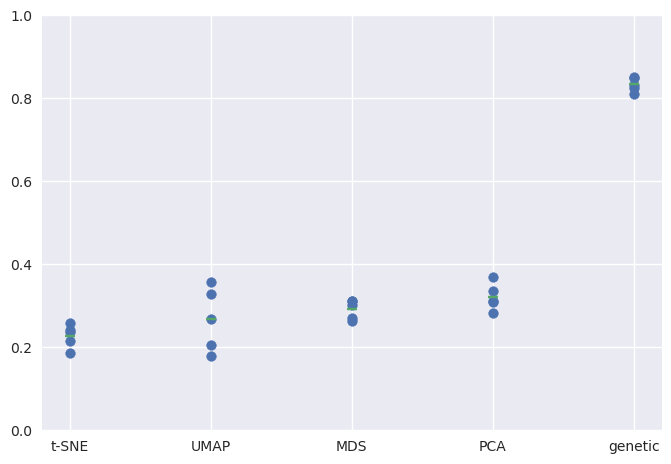

NameError: name 'snakemake' is not defined

In [33]:
plt.scatter(x=cross_v_info["method"], y=cross_v_info["matthews_cc"])
plt.scatter(x=cross_v_info["method"], y=cross_v_info["mean"], marker="_")
plt.ylim(0, 1)
plt.show()

#plt.savefig(snakemake.output.cross_v_data)

# Old Code

## Load clade membership annotations

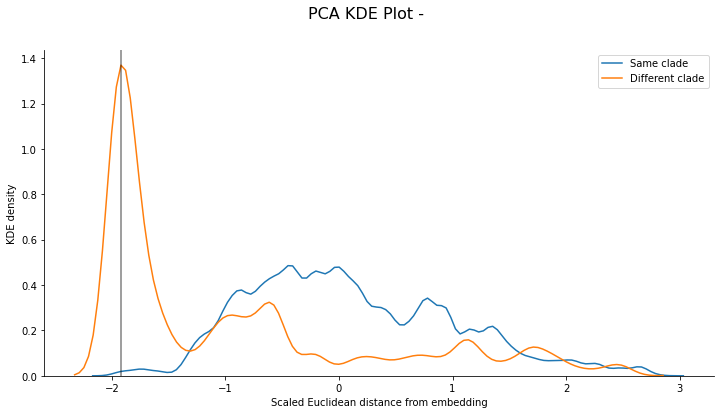

In [138]:
KDE_df = pd.read_csv(KDE_pca_path, index_col=0)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=average_pca, label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")


fig.suptitle('PCA' + ' KDE Plot - ', fontsize=16)
sns.despine()


In [24]:
fold_factory = KFold(n_splits=5, shuffle=True)
folds = fold_factory.split(sequence_names)

In [20]:
total_list=[]
for k, (training_index, validation_index) in enumerate(folds): 
    for embed in default_tuned_values:
        print(f"Fit to fold: {k}")
        # Subset distance matrix to training indices.
        training_distance_matrix = distance_matrix[training_index][:, training_index]

        # Embed training distance matrix.
        embedder = embedding_class(**embedding_parameters)
        training_embedding = embedder.fit_transform(training_distance_matrix)

        # Calculate Euclidean distance between pairs of samples in the embedding.
        # The output is a condensed distance matrix with distances between pairs.
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        training_embedding_distances = pdist(training_embedding).reshape(-1, 1)

        # Assign a binary class to each pair of samples based on their clade memberships.
        # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
        # This vector of binary values will be the output to fit a classifier to.
        # These pairs should be in the same order as the embedding distances above.
        training_clade_status_for_pairs = assign_clade_status_to_pairs(
            clade_annotations,
            training_index
        )

        # Use a support vector machine classifier to identify an optimal threshold
        # to distinguish between within and between class pairs.
        # See also: https://scikit-learn.org/stable/modules/svm.html#svm-classification
        classifier = make_pipeline(
            StandardScaler(),
            LinearSVC(random_state=0, tol=1e-5)
        )

        classifier.fit(training_embedding_distances, training_clade_status_for_pairs)

        classifier_threshold = (0.5 - classifier.named_steps["linearsvc"].intercept_) / classifier.named_steps["linearsvc"].coef_[0]
        classifier_thresholds.append(classifier_threshold)

        # Use a SVM to identify an optimal threshold for genetic distances.
        genetic_classifier = make_pipeline(
            StandardScaler(),
            LinearSVC(random_state=0, tol=1e-5)
        )
        genetic_classifier.fit(squareform(training_distance_matrix).reshape(-1, 1), training_clade_status_for_pairs)

        # Subset distance matrix to validation indices.
        validation_distance_matrix = distance_matrix[validation_index][:, validation_index]

        # Embed validation distance matrix.
        validation_embedding = embedder.fit_transform(validation_distance_matrix)

        # Calculate Euclidean distance between pairs of samples in the embedding.
        # The output should be a data frame of distances between pairs.
        validation_embedding_distances = pdist(validation_embedding).reshape(-1, 1)

        # Assign a binary class to each pair of samples based on their clade memberships.
        # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
        # This vector of binary values will be the output to fit a classifier to.
        # These pairs should be in the same order as the embedding distances above.
        validation_clade_status_for_pairs = assign_clade_status_to_pairs(
            clade_annotations,
            validation_index
        )

        # Predict and score clade status from embedding distances and the trained classifier.
        # The first argument is the set to predict classifier labels for. The second argument
        # is the list of true labels. The return argument is the mean accuracy of the predicted
        # labels.
        # https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.score

        confusion_matrix_val = confusion_matrix(classifier.predict(validation_embedding_distances), validation_clade_status_for_pairs)
        matthews_cc_val = matthews_corrcoef(classifier.predict(validation_embedding_distances), validation_clade_status_for_pairs)

        accuracy = classifier.score(
            validation_embedding_distances,
            validation_clade_status_for_pairs
        )
        print(f"Accuracy: {accuracy}")

        genetic_accuracy = genetic_classifier.score(
            squareform(validation_distance_matrix).reshape(-1, 1),
            validation_clade_status_for_pairs
        )
        print(f"Genetic accuracy: {genetic_accuracy}")
        print()

        accuracies.append(accuracy)
        genetic_accuracies.append(genetic_accuracy)

        method_dict = {}

        method_dict["method"] = list_of_embeddings_strings[i]
        method_dict["fold"] = k
        method_dict["confusion_matrix"] = confusion_matrix_val
        method_dict["matthews_cc"] = matthews_cc_val
        method_dict["threshold"] = classifier_threshold
        method_dict["accuracy"] = accuracy
        method_dict["genetic_accuracy"] = genetic_accuracy

        print(method_dict)
        total_list.append(method_dict)


Fit to fold: 0
Accuracy: 0.8947788114676286
Genetic accuracy: 0.9240934118093792

Fit to fold: 1
Accuracy: 0.8910195557243212
Genetic accuracy: 0.9346497057148282

Fit to fold: 2
Accuracy: 0.8803340228300007
Genetic accuracy: 0.9267601317704742

Fit to fold: 3
Accuracy: 0.8923619091396614
Genetic accuracy: 0.9275262391787329

Fit to fold: 4
Accuracy: 0.8814448785719758
Genetic accuracy: 0.9324293265915882



In [43]:
training_embedding_df = pd.DataFrame(training_embedding, columns=["x", "y"])
training_embedding_df["clade_membership"] = clade_annotations.loc[training_index, "clade_membership"].values

In [44]:
validation_embedding_df = pd.DataFrame(validation_embedding, columns=["x", "y"])
validation_embedding_df["clade_membership"] = clade_annotations.loc[validation_index, "clade_membership"].values

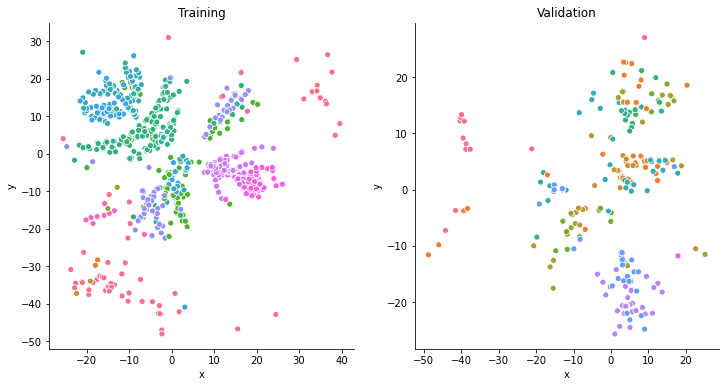

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot("x", "y", hue="clade_membership", data=training_embedding_df, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("x", "y", hue="clade_membership", data=validation_embedding_df, legend=False, ax=axes[1])
axes[1].set_title("Validation")

sns.despine()

In [46]:
training_embedding_distances.shape

(419986, 1)

In [47]:
training_clade_status_for_pairs.shape

(419986,)

In [48]:
training_embedding_distances.flatten()

array([14.00615474, 63.47261105, 22.14950939, ..., 53.16887278,
       72.08460183, 19.19231246])

In [49]:
scaler = StandardScaler()

In [50]:
scaler.fit_transform(training_embedding_distances)

array([[-0.65736654],
       [ 3.14147981],
       [-0.03198612],
       ...,
       [ 2.35018968],
       [ 3.8028498 ],
       [-0.25908824]])

In [51]:
distances_df = pd.DataFrame({"distance": training_embedding_distances.flatten(), "same_clade": training_clade_status_for_pairs.flatten()})

In [53]:
distances_df["scaled_distance"] = scaler.fit_transform(training_embedding_distances).flatten()

In [54]:
distances_df["genetic_distance"] = squareform(training_distance_matrix)

In [52]:
distances_df.head()

,distance,same_clade
0,14.006155,1
1,63.472611,1
2,22.149509,1
3,65.947260,1
4,62.232793,1


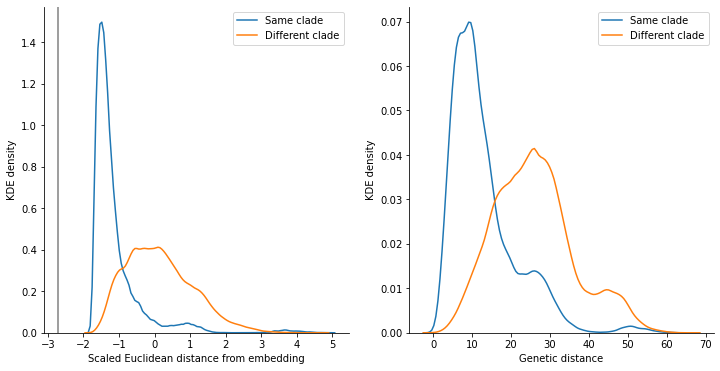

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(distances_df.query("same_clade == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(distances_df.query("same_clade == 0")["scaled_distance"], label="Different clade", ax=ax)

for classifier_threshold in classifier_thresholds:
    ax.axvline(x=classifier_threshold, label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(distances_df.query("same_clade == 1")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(distances_df.query("same_clade == 0")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

sns.despine()

## Plot and summarize accuracies

In [ ]:
# Print the mean accuracy and stddev
print(f"Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bins = np.arange(0, 1.01, 0.05)

ax.hist(accuracies, bins=bins)

ax.axvline(
    x=np.mean(accuracies),
    label=f"Mean accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}",
    color="orange"
)

ax.set_xlabel("Accuracy of classifier")
ax.set_ylabel("Number of cross-validation folds")

ax.legend(frameon=False)

sns.despine()

## Plot classifier thresholds

The linear support vector classifier (SVC) produces an intercept and coefficient for a single feature that represents a line through the domain of the input data that classifies samples into "same clade" (1) or "different clade" (0). The midpoint between these classification labels (0.5) is useful for visualizing the placement of the SVC results. We calculate the value of the input domain that corresponds to this line by solving for $0.5 = mx + b$ where $x$ is the value of interest from the input domain.

Below we plot the resulting distribution of classifier thresholds across all *k* folds to get a sense of how consistent these values are across training sets. Note that the input data have been scaled to z-values (centered by their mean and divided by their standard deviation).

In [ ]:
classifier_thresholds = np.array(classifier_thresholds).flatten()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(classifier_thresholds.flatten(), bins=10)

ax.axvline(
    x=np.mean(classifier_thresholds),
    label=f"Mean classifier threshold: {np.mean(classifier_thresholds):.2f} +/- {np.std(classifier_thresholds):.2f}",
    color="orange"
)

ax.set_xlabel("Classifier threshold on scaled Euclidean distances")
ax.set_ylabel("Number of cross-validation folds")

ax.legend(frameon=False)

sns.despine()